# French incremental death analysis, geographical analysis

## Objective

The goal of this notebook is to use the INSEE death records to track which french area have been hit the most.

In [100]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

plt.rcParams['figure.figsize'] = (21, 14)

Populating the interactive namespace from numpy and matplotlib


## Prepare data

### "Communes" (towns) boundaries

In [3]:
geo = gpd.read_file('../data/processed/geo/commune_insee_cp_epci_2020.shp')

In [21]:
# our dataset has repeted lines for each postal code of a single city (bigger cities can have multiple postal code)
# since we don't use postal codes here we'll just drop the duplicates
geo = geo.drop_duplicates('insee_com')

### INSEE death data

In [145]:
# directly fetch only the last 10 years
death_logs = pd.read_parquet('../data/processed/death/insee_date-place-age-gender_1970_to_20200427.parquet').query('date_death >= "2010-01-01"')

In [146]:
death_day_place = death_logs.groupby(level=[0, 1]).agg({'nb_death': 'sum'})
death_day_place = death_day_place.reset_index()
death_day_place['fake_date'] = death_day_place.date_death.apply(lambda x: x.replace(year=2012))
death_day_place['year'] = death_day_place.date_death.dt.year

In [147]:
death_place_period = death_day_place.query('fake_date >= "2012-03-01" & fake_date <= "2012-04-27"').groupby(['insee_code_death', 'year'], as_index=False).agg({'nb_death': 'sum'})

## Incremental analysis on geographical data

Piece of advice: in the end, merge everything onto geo using how='left', this way you won't be leaving "holes" in your geographic data.

But here, we have to start enriching death data with geographical information since for now it has several values per insee_code: one for each year. By the way, beware of empty years!! They aren't present, but implicitly means 0 and shouldn't be omited because it will ruin the average computation afterwards! We'll see how to treat that farther away.

In the end, we'll be looking at data at these different levels:
- canton (code_cant + code_dept in our geographical dataset)
- arrondissement (code_arr + code_dept)
- departement (code_dept)

So the first step is to add these levels to our death dataset.

In [119]:
geo.loc[:, 'canton'] = geo.code_dept + '-' + geo.code_cant
geo.loc[:, 'canton'] = geo.canton.where(geo.canton.notna(), other=geo.nom_com_sa)
geo.loc[:, 'arrondissement'] = geo.code_dept + '-' + geo.code_arr

In [148]:
death_place_period = death_place_period.merge(geo[['insee_com', 'canton', 'arrondissement', 'code_dept']], how='inner', left_on='insee_code_death', right_on='insee_com')

In [149]:
death_period_canton = death_place_period.groupby(['canton', 'year'], as_index=True).agg({'nb_death': 'sum'})
death_period_arr = death_place_period.groupby(['arrondissement', 'year'], as_index=True).agg({'nb_death': 'sum'})
death_period_dept = death_place_period.groupby(['code_dept', 'year'], as_index=True).agg({'nb_death': 'sum'})

Now we have to accound for potential "holes" in the yearly data, especially for finer geographical granularities like canton. As we said before, we don't want to have missing data, we want zeros. To do this, we'll have some help from the very good pandas' MultiIndex methods.

In [150]:
index_canton = pd.MultiIndex.from_product(death_period_canton.index.levels, names=death_period_canton.index.names)
index_arr = pd.MultiIndex.from_product(death_period_arr.index.levels, names=death_period_arr.index.names)
index_dept = pd.MultiIndex.from_product(death_period_dept.index.levels, names=death_period_dept.index.names)

In [151]:
death_period_canton = death_period_canton.reindex(index_canton, fill_value=0)
death_period_arr = death_period_arr.reindex(index_arr, fill_value=0)
death_period_dept = death_period_dept.reindex(index_dept, fill_value=0)

In [152]:
# some more MultiIndex gymnastics :)
death_period_canton_avg = death_period_canton.loc[(slice(None), slice(2010, 2019)), :].groupby(level=0).agg({'nb_death': 'mean'})
death_period_canton_2020 = death_period_canton.loc[(slice(None), 2020), :].droplevel(1)

death_period_arr_avg = death_period_arr.loc[(slice(None), slice(2010, 2019)), :].groupby(level=0).agg({'nb_death': 'mean'})
death_period_arr_2020 = death_period_arr.loc[(slice(None), 2020), :].droplevel(1)

death_period_dept_avg = death_period_dept.loc[(slice(None), slice(2010, 2019)), :].groupby(level=0).agg({'nb_death': 'mean'})
death_period_dept_2020 = death_period_dept.loc[(slice(None), 2020), :].droplevel(1)

We're ready to merge onto geo!

In [153]:
# this takes a bit of time (dissolve makes the union of all the commune's shapes, which means processing quite a lot of data)
geo_canton = geo[['canton', 'code_dept', 'geometry']].dissolve(by='canton')
geo_canton = geo_canton.merge(death_period_canton_avg.reset_index().rename(columns={'nb_death': 'death_avg'}), how='left', on='canton')
geo_canton = geo_canton.merge(death_period_canton_2020.reset_index().rename(columns={'nb_death': 'death_2020'}), how='left', on='canton')

geo_arr = geo[['arrondissement', 'code_dept', 'geometry']].dissolve(by='arrondissement')
geo_arr = geo_arr.merge(death_period_arr_avg.reset_index().rename(columns={'nb_death': 'death_avg'}), how='left', on='arrondissement')
geo_arr = geo_arr.merge(death_period_arr_2020.reset_index().rename(columns={'nb_death': 'death_2020'}), how='left', on='arrondissement')

geo_dept = geo[['code_dept', 'geometry']].dissolve(by='code_dept')
geo_dept = geo_dept.merge(death_period_dept_avg.reset_index().rename(columns={'nb_death': 'death_avg'}), how='left', on='code_dept')
geo_dept = geo_dept.merge(death_period_dept_2020.reset_index().rename(columns={'nb_death': 'death_2020'}), how='left', on='code_dept')

In [154]:
from scipy import stats as st

geo_canton['surmortality'] = geo_canton.eval('(death_2020 - death_avg) / death_avg')
geo_canton['poisson_sf'] = st.poisson.sf(geo_canton.death_avg, geo_canton.death_2020)
geo_canton.poisson_sf = geo_canton.poisson_sf.fillna(0.)
geo_canton['significant'] = geo_canton.eval('(poisson_sf < 0.05 | poisson_sf > 0.95) & (death_2020 > 1)')
geo_canton['surmortality_signif'] = geo_canton.surmortality.where(geo_canton.significant)

geo_arr['surmortality'] = geo_arr.eval('(death_2020 - death_avg) / death_avg')
geo_arr['poisson_sf'] = st.poisson.sf(geo_arr.death_avg, geo_arr.death_2020)
geo_arr.poisson_sf = geo_arr.poisson_sf.fillna(0.)
geo_arr['significant'] = geo_arr.eval('(poisson_sf < 0.05 | poisson_sf > 0.95) & (death_2020 > 1)')
geo_arr['surmortality_signif'] = geo_arr.surmortality.where(geo_arr.significant)

geo_dept['surmortality'] = geo_dept.eval('(death_2020 - death_avg) / death_avg')
geo_dept['poisson_sf'] = st.poisson.sf(geo_dept.death_avg, geo_dept.death_2020)
geo_dept.poisson_sf = geo_dept.poisson_sf.fillna(0.)
geo_dept['significant'] = geo_dept.eval('(poisson_sf < 0.05 | poisson_sf > 0.95) & (death_2020 > 1)')
geo_dept['surmortality_signif'] = geo_dept.surmortality.where(geo_dept.significant)

/Users/nathan/miniconda3/envs/covid19inc-env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:598: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0
/Users/nathan/miniconda3/envs/covid19inc-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:3153: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/Users/nathan/miniconda3/envs/covid19inc-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:3153: RuntimeWarning: invalid value encountered in less
  cond1 = (k >= _a) & (k < _b)
/Users/nathan/miniconda3/envs/covid19inc-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:3154: RuntimeWarning: invalid value encountered in less
  cond2 = (k < _a) & cond0


In [155]:
geo_canton

,canton,geometry,code_dept,death_avg,death_2020,surmortality,poisson_sf,significant,surmortality_signif
0,01-01,"POLYGON ((611252.844 5766613.319, 611267.130 5...",01,34.0,44.0,0.294118,0.928236,False,NaN
1,01-02,"POLYGON ((573975.219 5810832.804, 573961.102 5...",01,12.4,14.0,0.129032,0.641542,False,NaN
2,01-03,"POLYGON ((646787.808 5779289.625, 646456.568 5...",01,12.2,18.0,0.475410,0.908331,False,NaN
3,01-04,"POLYGON ((627437.898 5719247.666, 627429.042 5...",01,47.3,60.0,0.268499,0.950823,True,0.268499
4,01-05,"POLYGON ((583870.181 5826764.943, 583817.326 5...",01,117.5,132.0,0.123404,0.898224,False,NaN
...,...,...,...,...,...,...,...,...,...
2110,TASSIN-LA-DEMI-LUNE,"POLYGON ((533493.336 5744092.854, 533488.637 5...",69,7.4,15.0,1.027027,0.981998,True,1.027027
2111,VAULX-EN-VELIN,"POLYGON ((547424.046 5740104.673, 547450.936 5...",69,16.8,31.0,0.845238,0.997662,True,0.845238
2112,VENISSIEUX,"POLYGON ((546528.943 5735260.281, 546140.806 5...",69,18.8,37.0,0.968085,0.999579,True,0.968085
2113,VERNAISON,"POLYGON ((533881.707 5722365.171, 533910.903 5...",69,6.5,10.0,0.538462,0.869859,False,NaN


In [140]:
sns.set_context('talk')

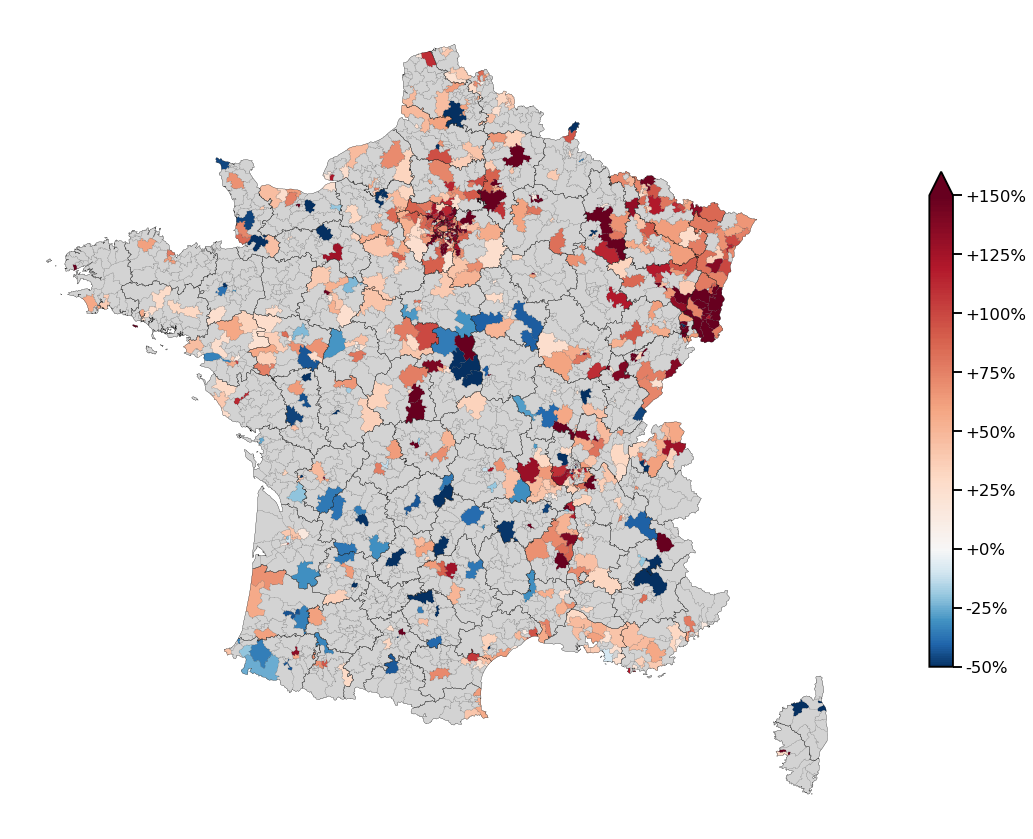

In [156]:
norm = matplotlib.colors.TwoSlopeNorm(vmin=-.5, vcenter=0., vmax=1.5)
cmap = plt.cm.RdBu_r

fig = figure(figsize=(18, 12), facecolor='w')
ax = fig.add_subplot(111)
pr = geo_canton.loc[~geo_canton.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
    column='surmortality_signif', cmap=cmap, linewidth=0.1, edgecolor='k',
    ax=ax, norm=norm,
    missing_kwds={'facecolor': 'lightgray'}
)
pr2 = geo_dept.loc[~geo_dept.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
    linewidth=0.2, edgecolor='k',
    ax=ax, color='none',
)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6, extend='max')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(['{:+.0%}'.format(i) for i in cbar.get_ticks()])


# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
sns.despine(top=True, bottom=True, right=True, left=True)
tight_layout()



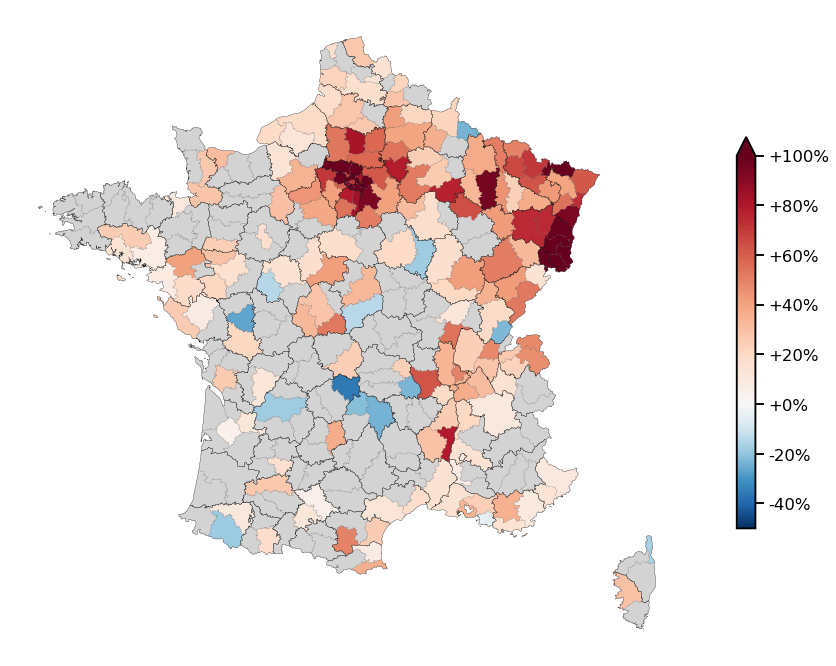

In [157]:
norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=1.)
cmap = plt.cm.RdBu_r

fig = figure(figsize=(18, 12))
ax = fig.add_subplot(111)
pr = geo_arr.loc[~geo_arr.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
    column='surmortality_signif', cmap=cmap, linewidth=0.1, edgecolor='k',
    ax=ax, norm=norm,
    missing_kwds={'facecolor': 'lightgray'}
)
pr2 = geo_dept.loc[~geo_dept.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
    linewidth=0.2, edgecolor='k',
    ax=ax, color='none',
)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6, extend='max')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(['{:+.0%}'.format(i) for i in cbar.get_ticks()])


# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
sns.despine(top=True, bottom=True, right=True, left=True)



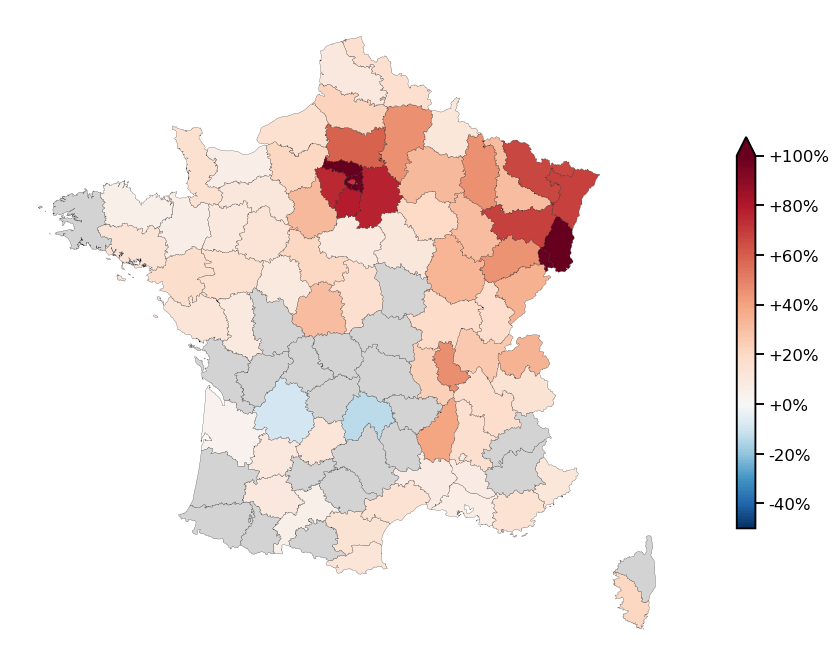

In [158]:
norm = matplotlib.colors.TwoSlopeNorm(vmin=-.5, vcenter=0., vmax=1.)
cmap = plt.cm.RdBu_r

fig = figure(figsize=(18, 12))
ax = fig.add_subplot(111)
pr = geo_dept.loc[~geo_dept.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
    column='surmortality_signif', cmap=cmap, linewidth=0.2, edgecolor='k',
    ax=ax, norm=norm,
    missing_kwds={'facecolor': 'lightgray'}
)
# pr2 = geo_dept.loc[~geo_dept.code_dept.isin({'97', '971', '972', '973', '974', '976'})].plot(
#     linewidth=0.2, edgecolor='k',
#     ax=ax, color='none',
# )

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6, extend='max')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(['{:+.0%}'.format(i) for i in cbar.get_ticks()])


# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
sns.despine(top=True, bottom=True, right=True, left=True)

